In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 2.8MB/s 


In [2]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
import pyro
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

from scipy.stats import norm

# for CI testing
smoke_test = ('CI' in os.environ)

pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Ex 1

In [0]:
def c_f(t1, t2):
    f = np.exp(- (t2 - t1)**2)
    return f

In [0]:
def G(x1, x2, y, t):
  g = 20.0 - x1**2 * x2 + 5.0 * x1 * (1 + y) * t - (x2 + 1) * t**2
  return g

In [0]:
def get_cov(t):
  cov = np.ones((len(t), len(t)))
  for i in range(len(t)):
    for j in range(len(t)):
      cov[i,j] = c_f(t[i], t[j])
      
  return cov

In [0]:
mean = [0, 0, 0, 0 , 0, 0]
t = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
cov = get_cov(t)

In [7]:
print(cov)

[[1.         0.96078944 0.85214379 0.69767633 0.52729242 0.36787944]
 [0.96078944 1.         0.96078944 0.85214379 0.69767633 0.52729242]
 [0.85214379 0.96078944 1.         0.96078944 0.85214379 0.69767633]
 [0.69767633 0.85214379 0.96078944 1.         0.96078944 0.85214379]
 [0.52729242 0.69767633 0.85214379 0.96078944 1.         0.96078944]
 [0.36787944 0.52729242 0.69767633 0.85214379 0.96078944 1.        ]]


In [0]:
Nsample = int(1e6)
# np.random.multivariate_normal(mean, cov, size)
y = np.random.multivariate_normal(mean, cov, Nsample).T

In [0]:
x1 = np.random.normal(loc=3.5, scale=0.25, size=Nsample)
x2 = np.random.normal(loc=3.5, scale=0.25, size=Nsample)

In [10]:
list_Pf = []
for i in range(len(t)):
  g = G(x1, x2, y[i], t[i])
  Pf = len(np.where( g > 0)[0]) / Nsample
  list_Pf.append(Pf)

list_Pf

[1.2e-05, 0.001333, 0.031162, 0.119801, 0.218439, 0.296343]

In [0]:
a1e4=  [0.0001, 0.0011, 0.0287, 0.1132, 0.2108, 0.2862]
a1e5=  [2e-05, 0.0013, 0.03066, 0.11997, 0.21872, 0.29818]
a1e6=  [1.4e-05, 0.001341, 0.031174, 0.119575, 0.218297, 0.296146]
a1e7=  [1.69e-05, 0.0013045, 0.0312792, 0.1199282, 0.2186738, 0.2964822]
aref=  [0         , 0.00144, 0.03050, 0.11820, 0.21952, 0.29860]

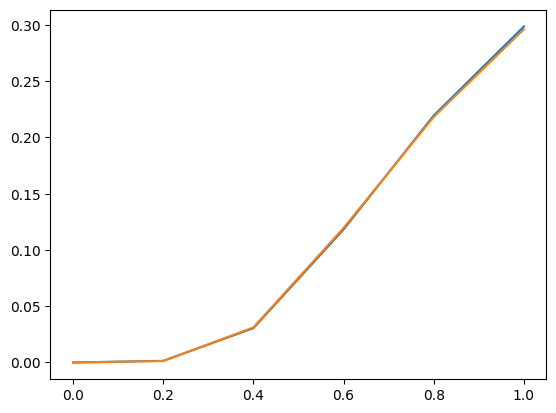

In [12]:
plt.plot(t, aref, t, a1e6)

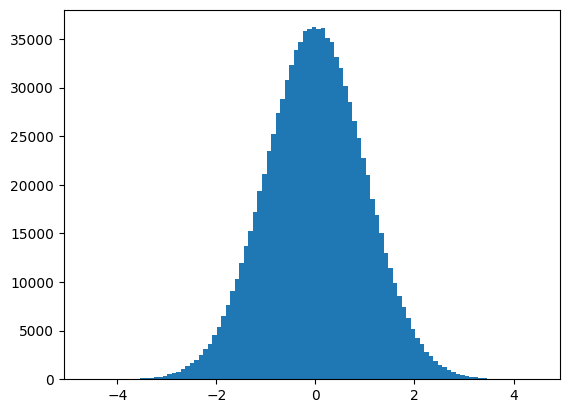

In [13]:
plt.hist(y[-1], bins=100);

## Database

In [0]:
def c_f(t1, t2):
    f = np.exp(- (t2 - t1)**2)
    return f

In [0]:
def get_cov(t):
  cov = np.ones((len(t), len(t)))
  for i in range(len(t)):
    for j in range(len(t)):
      cov[i,j] = c_f(t[i], t[j])
      
  return cov

In [0]:
def G(x1, x2, y, t):
  g = 20.0 - x1**2 * x2 + 5.0 * x1 * (1 + y) * t - (x2 + 1) * t**2
  return g

In [0]:
t = [0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0]
mean = [0.0] * len(t)
cov = get_cov(t)

In [0]:
Nsample = int(1e4)
y = np.random.multivariate_normal(mean, cov, Nsample).T
x1 = np.random.normal(loc=3.5, scale=0.25, size=Nsample)
x2 = np.random.normal(loc=3.5, scale=0.25, size=Nsample)

gg = []
for i in range(len(t)):
  g = G(x1, x2, y[i], t[i])
  gg.append(g)

In [107]:
Y = np.array(y).reshape(-1,1)
T = np.ones((Nsample, len(t))) * t
T = T.T.reshape(-1,1)
X1 = np.array(list(x1)*len(t))
X1 = X1.reshape(-1,1)
X2 = np.array(list(x2)*len(t))
X2 = X2.reshape(-1,1)

XX = np.concatenate((X1, X2, Y, T),axis = 1)
YY = np.array(gg).reshape(-1)

x_data = torch.tensor(XX, dtype=torch.float)
y_data = torch.tensor(YY/10, dtype=torch.float)
x_data.size()


torch.Size([90000, 4])

In [0]:
def ref_Pf(t, Nsample=int(1e6)):
  mean = [0.0] * len(t)
  cov = get_cov(t)  
  y = np.random.multivariate_normal(mean, cov, Nsample).T
  x1 = np.random.normal(loc=3.5, scale=0.25, size=Nsample)
  x2 = np.random.normal(loc=3.5, scale=0.25, size=Nsample)

  list_Pf = [0]
  for i in range(len(t)):
    g = G(x1, x2, y[i], t[i])
    Pf = getPf(g, Nsample)
    list_Pf.append(Pf)

  return list_Pf


## BUILD BNN model

In [0]:
def g_BNN(x1, x2, y, t, model, guide, num_samples=100):

  Y = np.array(y).reshape(-1,1)
  T = np.ones((len(x1), 1)) * t
  T = T.T.reshape(-1,1)
  X1 = np.array(list(x1))
  X1 = X1.reshape(-1,1)
  X2 = np.array(list(x2))
  X2 = X2.reshape(-1,1)
  XX = np.concatenate((X1, X2, Y, T),axis = 1)
  x_data = torch.tensor(XX, dtype=torch.float)

  predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=("linear.weight", "obs", "_RETURN"))
  samples = predictive(x_data)
  pred = summary(samples)
  y_pred = pred['_RETURN']['mean']  
  y_5 = pred['_RETURN']['5%']
  y_95 = pred['_RETURN']['95%']
  ys_pred = pred['obs']['mean']
  ys_5 = pred['obs']['5%']
  ys_95 = pred['obs']['95%']


  return y_pred, y_5, y_95, ys_pred, ys_5, ys_95

In [0]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [0]:
def getPf(g, Nsample):
  Pf = len(np.where( g > 0)[0]) / Nsample
  return Pf

In [0]:
class BNN(PyroModule):
    def __init__(self, s_features):
        super().__init__()

        i = 0
        self.fc1 = PyroModule[nn.Linear](s_features[i], s_features[i+1])
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([s_features[i+1], s_features[i]]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.).expand([s_features[i+1]]).to_event(1))
        self.relu = nn.ReLU()

        i = 1
        self.fc2 = PyroModule[nn.Linear](s_features[i], s_features[i+1])
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([s_features[i+1], s_features[i]]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 10.).expand([s_features[i+1]]).to_event(1))
        self.relu = nn.ReLU()

        i = 2
        self.fc3 = PyroModule[nn.Linear](s_features[i], s_features[i+1])
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([s_features[i+1], s_features[i]]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 10.).expand([s_features[i+1]]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10))
        x1 = x
        x1 = self.fc1(x1)
        x1 = self.relu(x1)
        x1 = self.fc2(x1)
        x1 = self.relu(x1)       
        mean = self.fc3(x1).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [108]:
in_size = x_data.size()[-1]
model = BNN([in_size, 64, 64, 1])
guide = AutoDiagonalNormal(model)
print(x_data.size())

torch.Size([90000, 4])


In [109]:
%%time
num_iterations = 5000
adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    loss = svi.step(x_data.view(-1, in_size), y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))

[iteration 0001] loss: 3.3531
[iteration 0101] loss: 3.2068
[iteration 0201] loss: 3.0007
[iteration 0301] loss: 2.5234
[iteration 0401] loss: 1.9813
[iteration 0501] loss: 1.6988
[iteration 0601] loss: 1.5708
[iteration 0701] loss: 1.6190
[iteration 0801] loss: 1.5048
[iteration 0901] loss: 1.2219
[iteration 1001] loss: 1.2155
[iteration 1101] loss: 1.5273
[iteration 1201] loss: 2.6189
[iteration 1301] loss: 2.1522
[iteration 1401] loss: 1.0599
[iteration 1501] loss: 1.4817
[iteration 1601] loss: 1.4725
[iteration 1701] loss: 0.7456
[iteration 1801] loss: 0.4207
[iteration 1901] loss: 0.3325
[iteration 2001] loss: 0.4506
[iteration 2101] loss: 0.2286
[iteration 2201] loss: 0.1294
[iteration 2301] loss: 0.2829
[iteration 2401] loss: -0.0582
[iteration 2501] loss: 0.2715
[iteration 2601] loss: 0.7649
[iteration 2701] loss: -0.0533
[iteration 2801] loss: -0.3112
[iteration 2901] loss: 0.1048
[iteration 3001] loss: -0.2813
[iteration 3101] loss: 0.0885
[iteration 3201] loss: 0.2006
[itera

In [69]:
%%time
def g1_BNN(x1, x2, y, t, model, guide, num_samples=100):

  Y = np.array(y).reshape(-1,1)
  T = np.ones((len(x1), 1)) * t
  T = T.T.reshape(-1,1)
  X1 = np.array(list(x1))
  X1 = X1.reshape(-1,1)
  X2 = np.array(list(x2))
  X2 = X2.reshape(-1,1)
  XX = np.concatenate((X1, X2, Y, T),axis = 1)
  x_data = torch.tensor(XX, dtype=torch.float)

  predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=("linear.weight", "obs", "_RETURN"))
  samples = predictive(x_data)
  pred = summary1(samples)
  y_pred = pred['_RETURN']['mean']  
  ys_pred = pred['obs']['mean']

  return y_pred, ys_pred

def summary1(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
        }
    return site_stats


aBNN = [0]
aBNNs = [0]

for i in range(len(t)):
  g, gs = g1_BNN(x1, x2, y[i], t[i], model, guide, num_samples=10)
  aBNN.append(getPf(g, Nsample))
  aBNNs.append(getPf(gs, Nsample))

print(len(x1))
print(aBNN)
print(aBNNs)

1000
[0, 0.005, 0.082, 0.146, 0.227, 0.296, 0.41, 0.429, 0.347, 0.31]
[0, 0.005, 0.079, 0.148, 0.228, 0.293, 0.409, 0.428, 0.349, 0.309]
CPU times: user 535 ms, sys: 3 ms, total: 538 ms
Wall time: 387 ms


In [111]:
%%time

aBNN = [0]
aBNN_5 = [0]
aBNN_95 = [0]
aBNNs = [0]
aBNNs_5 = [0]
aBNNs_95 = [0]

for i in range(len(t)):
  g, g5, g95, gs, gs5, gs95 = g_BNN(x1, x2, y[i], t[i], model, guide, num_samples=100)
  aBNN.append(getPf(g, Nsample))
  aBNN_5.append(getPf(g5, Nsample))
  aBNN_95.append(getPf(g95, Nsample))  
  aBNNs.append(getPf(gs, Nsample))
  aBNNs_5.append(getPf(gs5, Nsample))
  aBNNs_95.append(getPf(gs95, Nsample))  

print(len(x1))

10000
CPU times: user 11.9 s, sys: 7.47 s, total: 19.4 s
Wall time: 14.6 s


In [112]:
%%time
list_Pf = ref_Pf(t)

CPU times: user 884 ms, sys: 292 ms, total: 1.18 s
Wall time: 795 ms


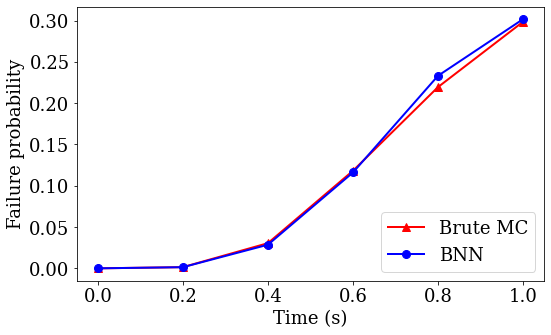

In [113]:
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 18
rcParams.update({'font.size': fsize})

fig = plt.figure(figsize=(8, 5))
gs = fig.add_gridspec(nrows=1, ncols=1)
tt = [0] + t

ax = fig.add_subplot(gs[0, 0])
ax.plot(tt[:6], aref[:6],'-^r', linewidth=2.0,  markersize=8)
ax.plot(tt[:6], aBNNs[:6],'-ob', linewidth=2.0,  markersize=8)
ax.set_xlabel('Time (s)');    
ax.set_ylabel('Failure probability');    
plt.legend(['Brute MC', 'BNN'],loc='lower right')
    
plt.tight_layout()    
# plt.savefig('reli_1.png', dpi=600)


In [73]:
print(aBNNs)
print(aBNNs_5)
print(aBNNs_95)

[0, 0.005, 0.064, 0.153, 0.231, 0.293, 0.41, 0.432, 0.347, 0.313]
[0, 0.002, 0.027, 0.109, 0.174, 0.23, 0.369, 0.409, 0.337, 0.293]
[0, 0.019, 0.114, 0.203, 0.294, 0.343, 0.447, 0.452, 0.368, 0.327]


In [137]:
list_Pf + np.random.randn(10,len(list_Pf))

array([ 0.8505716 ,  1.26587059,  1.05547762,  0.62613167, -0.92050308,
       -0.66357937, -0.84254002,  1.05514544,  0.82713106,  0.4416189 ])

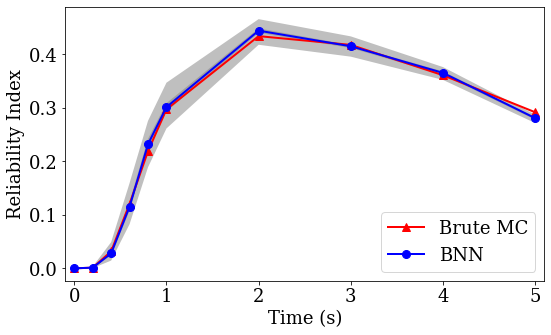

In [136]:
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 18
rcParams.update({'font.size': fsize})

fig = plt.figure(figsize=(8, 5))
gs = fig.add_gridspec(nrows=1, ncols=1)
tt = [0] + t

ax = fig.add_subplot(gs[0, 0])
ax.plot(tt, list_Pf,'-^r', linewidth=2.0,  markersize=8)
ax.plot(tt, aBNNs,'-ob', linewidth=2.0,  markersize=8)
ax.fill_between(tt, aBNN_5, aBNN_95, alpha=0.5, facecolor='gray')
ax.fill_between(tt, aBNNs_5, aBNNs_95, alpha=0.5, facecolor='gray')

ax.set_xlabel('Time (s)');    
ax.set_ylabel('Reliability Index');    
plt.legend(['Brute MC', 'BNN'],loc='lower right')

ax.set_xlim(-0.1,5.1);
    
plt.tight_layout()    
# plt.savefig('reli_2.png', dpi=600)


## Plot Confidence Interval

In [117]:
%%time

aBNN = [0]
aBNN_5 = [0]
aBNN_95 = [0]
aBNNs = [0]
aBNNs_5 = [0]
aBNNs_95 = [0]

for i in range(len(t)):
  g, g5, g95, gs, gs5, gs95 = g_BNN(x1, x2, y[i], t[i], model, guide, num_samples=1000)
  aBNN.append(getPf(g, Nsample))
  aBNN_5.append(getPf(g5, Nsample))
  aBNN_95.append(getPf(g95, Nsample))  
  aBNNs.append(getPf(gs, Nsample))
  aBNNs_5.append(getPf(gs5, Nsample))
  aBNNs_95.append(getPf(gs95, Nsample))  

print(len(x1))

10000
CPU times: user 1min 41s, sys: 2min 14s, total: 3min 56s
Wall time: 3min 15s


In [120]:
beta_ref = norm.isf(list_Pf)
beta_BNN = norm.isf(aBNNs)
beta_BNN_5 = norm.isf(aBNNs_5)
beta_BNN_95 = norm.isf(aBNNs_95)
print(beta_BNN_5)
print(beta_ref)
print(beta_BNN_95)

[       inf 3.35279478 2.18348653 1.38779329 0.88195711 0.63934272
 0.20778096 0.26501228 0.37965706 0.60828269]
[       inf 3.00982297 1.85692377 1.17272526 0.77575781 0.53277116
 0.16655272 0.20828301 0.35625447 0.54840186]
[       inf 2.70648331 1.65561407 0.99692689 0.59596292 0.39397432
 0.08633515 0.16772453 0.31573982 0.56158324]


In [0]:
 beta_BNN_5[1] = 3.2
beta_BNN_95[1] = 2.5
beta_BNN_5[6] = 0.24
# beta_BNN_95[5] = 0.45

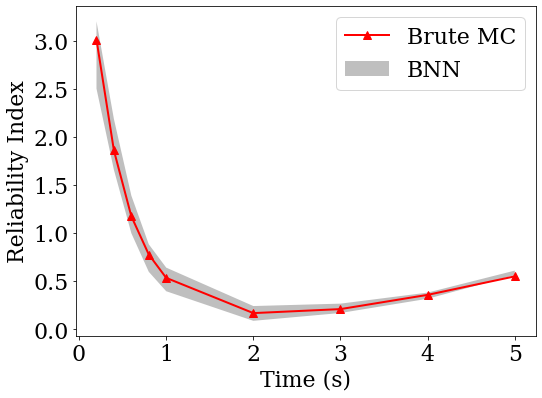

In [135]:
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 22
rcParams.update({'font.size': fsize})

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(nrows=1, ncols=1)


ax = fig.add_subplot(gs[0, 0])
ax.plot(t, beta_ref[1:],'-^r', linewidth=2.0,  markersize=8)
# ax.plot(t, beta_BNN[1:],'-ob', linewidth=2.0,  markersize=8)
ax.fill_between(t, beta_BNN_5[1:], beta_BNN_95[1:], alpha=0.5, facecolor='gray')

ax.set_xlabel('Time (s)');    
ax.set_ylabel('Reliability Index');    
plt.legend(['Brute MC', 'BNN'],loc='upper right')

# ax.set_ylim(0.0,10.0);
# ax.set_xlim(-0.1,5.1);
    
plt.tight_layout()    
plt.savefig('reli_1e4.png', dpi=600)


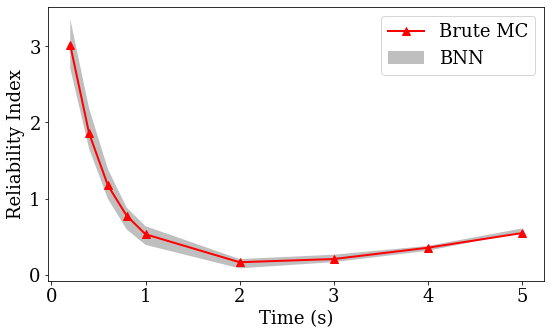

In [122]:
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 18
rcParams.update({'font.size': fsize})

fig = plt.figure(figsize=(8, 5))
gs = fig.add_gridspec(nrows=1, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(t, beta_ref[1:],'-^r', linewidth=2.0,  markersize=8)
# ax.plot(t, beta_BNN[1:],'-ob', linewidth=2.0,  markersize=8)
ax.fill_between(t, beta_BNN_5[1:], beta_BNN_95[1:], alpha=0.5, facecolor='gray')

ax.set_xlabel('Time (s)');    
ax.set_ylabel('Reliability Index');    
plt.legend(['Brute MC', 'BNN'],loc='upper right')

# ax.set_ylim(0.0,10.0);
# ax.set_xlim(-0.1,5.1);
    
plt.tight_layout()    
# plt.savefig('reli_1e3.png', dpi=600)


In [0]:
t

[0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0]

In [0]:
class BayesianRegression2(PyroModule):
    def __init__(self, in_features, h_features, out_features):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](in_features, h_features)
        self.linear1.weight = PyroSample(dist.Normal(0., 1.).expand([h_features, in_features]).to_event(2))
        self.linear1.bias = PyroSample(dist.Normal(0., 10.).expand([h_features]).to_event(1))

        self.linear2 = PyroModule[nn.Linear](h_features, out_features)
        self.linear2.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, h_features]).to_event(2))
        self.linear2.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))


    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        x1 = self.linear1(x)
        mean = self.linear2(x1).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [0]:

DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [0]:
len(df)

170

In [0]:
df.head()

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


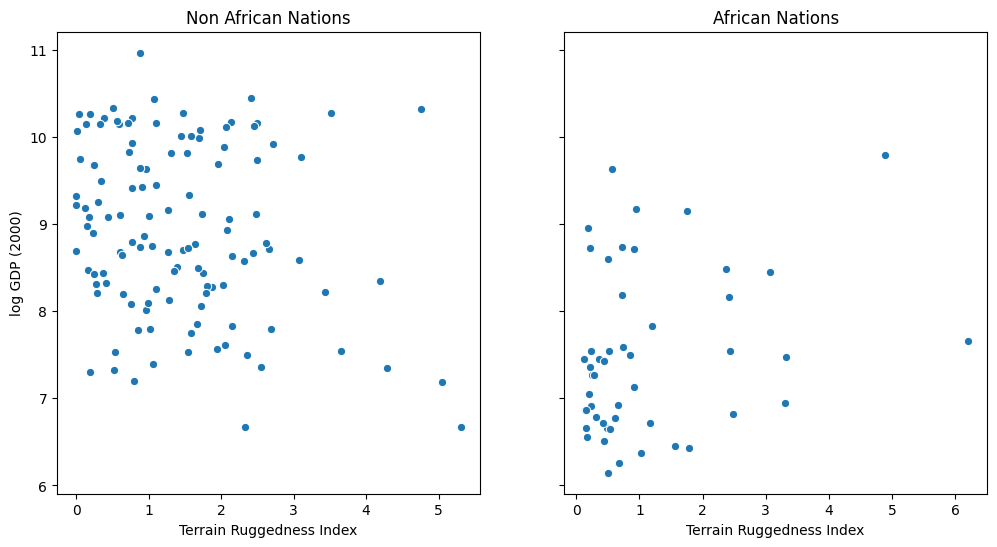

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [0]:
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]

In [0]:
df.head()

,cont_africa,rugged,rgdppc_2000,cont_africa_x_rugged
2,1,0.858,7.492609,0.858
4,0,3.427,8.216929,0.000
7,0,0.769,9.933263,0.000
8,0,0.775,9.407032,0.000
9,0,2.688,7.792343,0.000


In [0]:
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values, dtype=torch.float)

In [0]:
x_data, y_data = data[:, :-1], data[:, -1]

In [0]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [0]:
model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [0]:
num_iterations = 1500 
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))

[iteration 0001] loss: 1.4721
[iteration 0101] loss: 1.4613
[iteration 0201] loss: 1.4557
[iteration 0301] loss: 1.4600
[iteration 0401] loss: 1.4590
[iteration 0501] loss: 1.5258
[iteration 0601] loss: 1.4778
[iteration 0701] loss: 1.4597
[iteration 0801] loss: 1.4658
[iteration 0901] loss: 1.4930
[iteration 1001] loss: 1.4642
[iteration 1101] loss: 1.5358
[iteration 1201] loss: 1.4683
[iteration 1301] loss: 1.4658
[iteration 1401] loss: 1.4678


In [0]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2971, -1.8660, -0.1774,  0.2916,  9.1980])
AutoDiagonalNormal.scale tensor([0.0564, 0.1463, 0.0454, 0.0945, 0.0771])


In [0]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


In [0]:
predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [0]:
samples.keys()

dict_keys(['linear.weight', 'obs', '_RETURN'])

In [0]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

In [0]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]


In [0]:
y['mean'][:5]

tensor([7.4052, 8.6584, 9.0133, 9.0223, 8.6867])

In [0]:
y_data[:5]

tensor([7.4926, 8.2169, 9.9333, 9.4070, 7.7923])

In [0]:
predictions.head()

,cont_africa,rugged,mu_mean,mu_perc_5,mu_perc_95,y_mean,y_perc_5,y_perc_95,true_gdp
0,1.0,0.858,7.555674,7.244160,7.864501,7.601368,5.819968,9.300538,7.492610
1,0.0,3.427,8.681877,8.436876,8.931727,8.662459,6.948818,10.210230,8.216929
2,0.0,0.769,9.082697,8.951882,9.213259,9.076014,7.485076,10.679414,9.933263
3,0.0,0.775,9.081794,8.950770,9.212543,9.066601,7.443042,10.641148,9.407031
4,0.0,2.688,8.793317,8.593460,9.008084,8.809918,7.235983,10.369424,7.792343


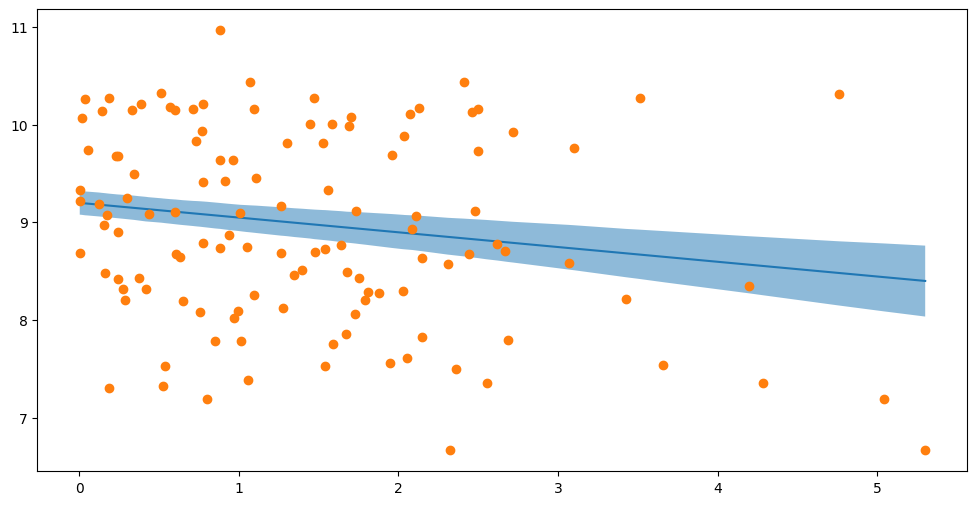

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharey=True)

non_african_nations = predictions[predictions["cont_africa"] == 0]
non_african_nations = non_african_nations.sort_values(by=["rugged"])

ax.plot(non_african_nations["rugged"],  non_african_nations["mu_mean"])
ax.fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax.plot(non_african_nations["rugged"], non_african_nations["true_gdp"],"o")


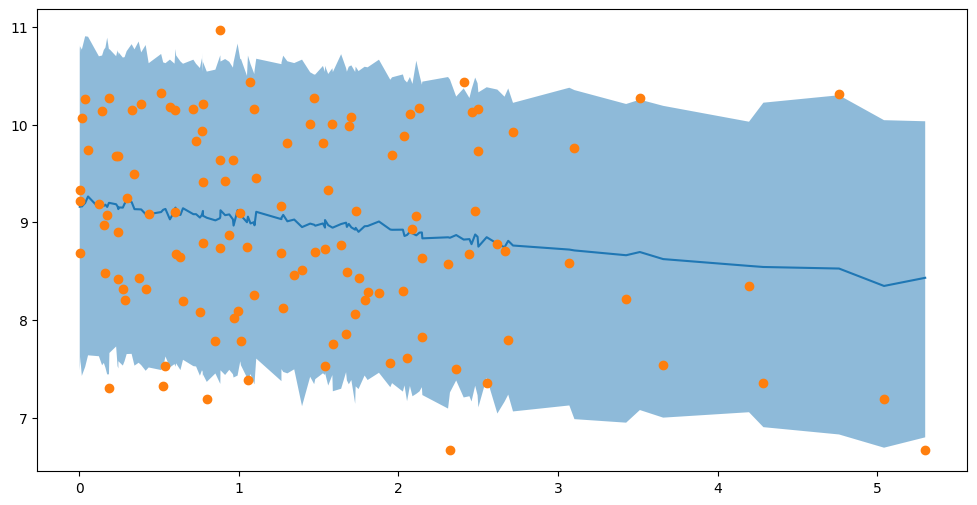

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharey=True)
ax.plot(non_african_nations["rugged"],non_african_nations["y_mean"])
ax.fill_between(non_african_nations["rugged"],non_african_nations["y_perc_5"],non_african_nations["y_perc_95"],alpha=0.5)
ax.plot(non_african_nations["rugged"], non_african_nations["true_gdp"],"o")


In [0]:
weight = samples["linear.weight"]

In [0]:
type(weight)

torch.Tensor

In [0]:
weight.size()

torch.Size([800, 1, 1, 3])

In [0]:
weight = weight.reshape(weight.shape[0], 3)
weight.size()

torch.Size([800, 3])

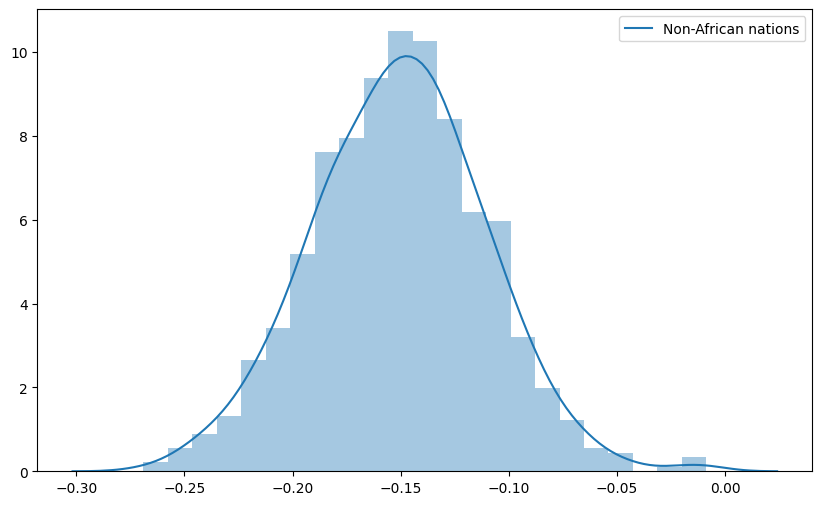

In [0]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})


In [0]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from pyro.nn import PyroModule
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal

# for CI testing
smoke_test = ('CI' in os.environ)

pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [0]:
import pickle

In [0]:
with open('Bex1.p','rb') as f:
  x_data =pickle.load(f)
  y_data =pickle.load(f)

170

In [0]:
class NN(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.out = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        output = self.out(x)
        return output


In [0]:
net = NN(3, 1)

In [0]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [0]:
softplus = torch.nn.Softplus()

In [0]:
def model0(x_data, y_data):
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight)).independent(1)
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias)).independent(1)
    
    priors = {'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_module()   
    mean = lifted_reg_model(x_data).squeeze(-1)
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    with pyro.plate("data", x_data.shape[0]):
      obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y_data)




In [0]:
def guide0(x_data, y_data):
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(2)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param).independent(1)
    priors = {'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    return lifted_module()

In [0]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [0]:
class BayesianRegression2(PyroModule):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](in_features, hidden_features)
        self.linear1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_features, in_features]).to_event(2))
        self.linear1.bias = PyroSample(dist.Normal(0., 10.).expand([hidden_features]).to_event(1))

        self.linear2 = PyroModule[nn.Linear](hidden_features, out_features)
        self.linear2.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, hidden_features]).to_event(2))
        self.linea2.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))


    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        x1 = self.linear1(x)
        mean = self.linear2(x1).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [0]:
model = BayesianRegression2(3, 5, 1)

AttributeError: ignored

In [0]:
guide = AutoDiagonalNormal(model)

In [0]:
num_iterations = 500 
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
# svi = SVI(model0, guide, adam, loss=Trace_ELBO())

In [0]:
pyro.clear_param_store()
for j in range(num_iterations):
    loss = svi.step(x_data.view(-1,3), y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))

[iteration 0001] loss: 5.2017
[iteration 0101] loss: 3.3207
[iteration 0201] loss: 3.0832
[iteration 0301] loss: 2.7898
[iteration 0401] loss: 2.2086


In [0]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [0]:
predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data, y_data)
pred_summary = summary(samples)

NameError: ignored

In [0]:
x_data.size()

torch.Size([170, 3])

In [0]:
from pyro.distributions import Bernoulli, Categorical, MultivariateNormal, Normal

In [0]:
d = Bernoulli(0.5 * torch.ones(3,4,5)).to_event(1)
d.event_shape 

torch.Size([5])

In [0]:
assert d.batch_shape == (3,)
assert d.event_shape == (4,)
x = d.sample()
assert x.shape == (3, 4)
assert d.log_prob(x).shape == (3,)

In [0]:
d.batch_shape

torch.Size([3, 4])

In [0]:
x = d.sample()
x.shape

torch.Size([3, 4, 5])

In [0]:
d

Independent()